# Metadata Filtering with KDB.AI Vector Database
#### In this example, we will show how to use metadata filtering in a KDB.AI vector database to increase the speed and accuracy of vector similarity searches. We will also explore LLM powered data exploration with PandasAI.

#### Agenda:
1. Set Up
2. Data Import and Exploration with PandasAI
3. Set Up KDB.AI Vector Database
4. Insert Movie Data into the KDB.AI table
5. Run Filtered Similarity Searches on our KDB.AI vector database

## 1. Set Up
Installs, imports, and API Key setup

In [ ]:
!pip install pandasai

In [1]:
import pandas as pd
from pandasai import SmartDataframe
from pandasai.llm.openai import OpenAI
import os
from getpass import getpass

In [2]:
os.environ["OPENAI_API_KEY"] = (
    os.environ["OPENAI_API_KEY"]
    if "OPENAI_API_KEY" in os.environ
    else getpass("OpenAI API Key: ")
)

OpenAI API Key: ········


In [3]:
llm = OpenAI(model="gpt-3.5-turbo-1106")

## 2. Data Import and Exploration with PandasAI
### Import movies dataframe

In [4]:
# Read in the Movies dataframe
df = pd.read_pickle("./data/filtered_embedded_movies.pkl")

### Initial data exploration: Let's understand the data!

In [5]:
#How many rows do we have?
print(df.shape[0])

19161


In [6]:
#What columns do we have?
for column in df.columns:
    print(column)

ReleaseYear
Title
Origin
Director
Cast
Genre
Plot
embeddings


In [7]:
#Let us inspect the dataframe
df.head()

,ReleaseYear,Title,Origin,Director,Cast,Genre,Plot,embeddings
0,1975,The Candy Tangerine Man,American,Matt Cimber,John Daniels Eli Haines Tom Hankason,action,A successful Los Angeles-based businessperson ...,"[-0.06835174, -0.013138616, -0.12417501, 0.002..."
1,1975,Capone,American,Steve Carver,Ben Gazzara Susan Blakely John Cassavetes Sylv...,crime drama,The story is of the rise and fall of the Chica...,"[-0.01411798, 0.040705115, -0.0014280609, 0.00..."
2,1975,Cleopatra Jones and the Casino of Gold,American,Charles Bail,Tamara Dobson Stella Stevens,action,The story begins with two government agents Ma...,"[-0.0925895, 0.01188509, -0.08999529, -0.01541..."
3,1975,Conduct Unbecoming,American,Michael Anderson,Stacy Keach Richard Attenborough Christopher P...,drama,Around 1880 two young British officers arrive ...,"[-0.07435084, -0.06386179, 0.017042944, 0.0288..."
4,1975,Cooley High,American,Michael Schultz,Lawrence Hilton-Jacobs Glynn Turman Garrett Mo...,comedy,Set in 1964 Chicago Preach an aspiring playwri...,"[-0.041632336, 0.037923656, -0.072276264, -0.0..."


### Explore Data with PandasAI: 
Natural Language to Analytics

In [8]:
#Create a SmartDataFrame for use with PandasAI
df_pandas = SmartDataframe(df, config={"llm": llm})

In [9]:
df_pandas.chat('Which directors have directed the most movies?')

,Director,Count
0,Maurice Elvey,40
1,Val Guest,38
2,Gerald Thomas,38
3,Woody Allen,36
4,Ralph Thomas,32


In [14]:
df_pandas.chat('list all of the origin countries, what is the most popular genre in each country?')

,Origin,Most Popular Genre,Genre Count
0,American,comedy,1612
1,Assamese,drama,7
2,Australian,drama,132
3,Bangladeshi,drama,24
4,Bengali,romance,89
5,Bollywood,drama,325
6,British,drama,728
7,Canadian,drama,229
8,Chinese,drama,69
9,Egyptian,drama,35


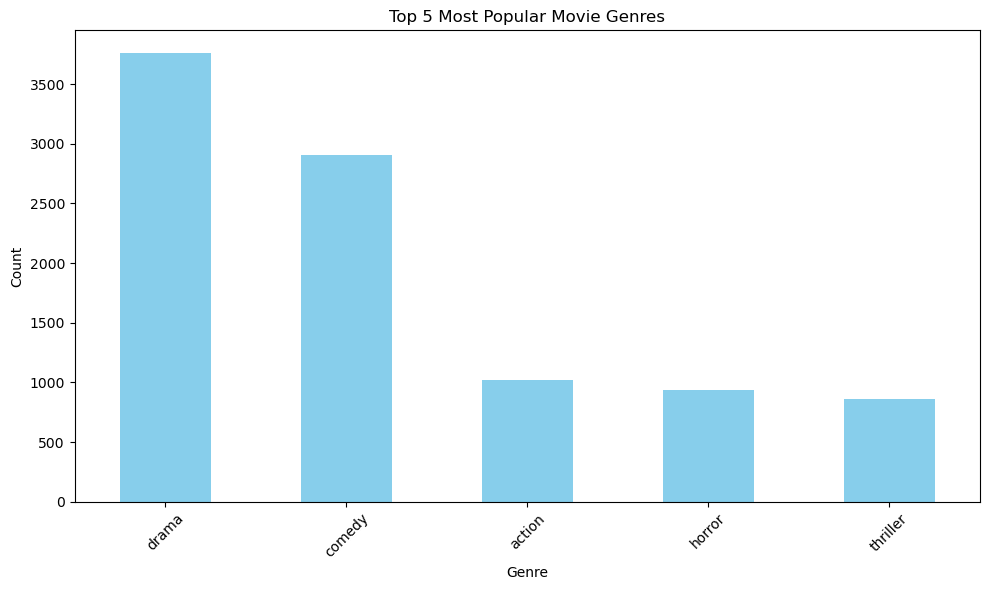

'C:/Users/rsiegler/OneDrive - First Derivatives Plc/Documents/demo_test/kdbai-samples/exports/charts/temp_chart.png'

In [32]:
#Can we make a graph?
df_pandas.chat('Which are the 5 most popular movie genres? Make a graph of the result')

## 3. Set up KDB.AI Vector Database
Now that we understand our dataset, we can set up our vector db

In [2]:
# vector DB
import os
from getpass import getpass
import kdbai_client as kdbai
import time

In [4]:
#Set up KDB.AI endpoing and API key
KDBAI_ENDPOINT = (
    os.environ["KDBAI_ENDPOINT"]
    if "KDBAI_ENDPOINT" in os.environ
    else input("KDB.AI endpoint: ")
)
KDBAI_API_KEY = (
    os.environ["KDBAI_API_KEY"]
    if "KDBAI_API_KEY" in os.environ
    else getpass("KDB.AI API key: ")
)

KDB.AI endpoint: your_kdbai_endpoint
KDB.AI API key: ········


In [17]:
session = kdbai.Session(api_key=KDBAI_API_KEY, endpoint=KDBAI_ENDPOINT)

### Set up the table schema
Have a table column for each column in the dataframe, as well as an 'embeddings' column for the movie description embeddings

In [18]:
#Set up the schema for KDB.AI table, specifying embeddings column with 384 dimensions, Euclidean Distance, and flat index
table_schema = {
    "columns": [
        {"name": "ReleaseYear", "pytype": "int64"},
        {"name": "Title", "pytype": "str"},
        {"name": "Origin", "pytype": "str"},
        {"name": "Director", "pytype": "str"},
        {"name": "Cast", "pytype": "str"},
        {"name": "Genre", "pytype": "str"},
        {"name": "Plot", "pytype": "str"},
        {
            "name": "embeddings",
            "pytype": "float32",
            "vectorIndex": {"dims": 384, "metric": "L2", "type": "flat"},
        },
    ]
}

### Create a table called "metadata_demo"
First check if the table already exists, then create a new table with the table schema from above

In [19]:
# First ensure the table does not already exist
try:
    session.table("metadata_demo").drop()
    time.sleep(5)
except kdbai.KDBAIException:
    pass

In [20]:
#Create the table called "metadata_demo"
table = session.create_table("metadata_demo", table_schema)

## 4. Insert Movie Data into the KDB.AI table 

In [21]:
#Insert the data into the table, split into 2000 row batches
from tqdm import tqdm 
n = 2000  # chunk row size

for i in tqdm(range(0, df.shape[0], n)):
    table.insert(df[i:i+n].reset_index(drop=True))

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:40<00:00,  4.00s/it]


In [22]:
#function to view the dataframe within the table
def show_df(df: pd.DataFrame) -> pd.DataFrame:
    print(df.shape)
    return df.head()

In [23]:
#View contents of the table
show_df(table.query())

(19161, 8)


,ReleaseYear,Title,Origin,Director,Cast,Genre,Plot,embeddings
0,1975,The Candy Tangerine Man,American,Matt Cimber,John Daniels Eli Haines Tom Hankason,action,A successful Los Angeles-based businessperson ...,"[-0.06835174, -0.013138616, -0.12417501, 0.002..."
1,1975,Capone,American,Steve Carver,Ben Gazzara Susan Blakely John Cassavetes Sylv...,crime drama,The story is of the rise and fall of the Chica...,"[-0.01411798, 0.040705115, -0.0014280609, 0.00..."
2,1975,Cleopatra Jones and the Casino of Gold,American,Charles Bail,Tamara Dobson Stella Stevens,action,The story begins with two government agents Ma...,"[-0.0925895, 0.01188509, -0.08999529, -0.01541..."
3,1975,Conduct Unbecoming,American,Michael Anderson,Stacy Keach Richard Attenborough Christopher P...,drama,Around 1880 two young British officers arrive ...,"[-0.07435084, -0.06386179, 0.017042944, 0.0288..."
4,1975,Cooley High,American,Michael Schultz,Lawrence Hilton-Jacobs Glynn Turman Garrett Mo...,comedy,Set in 1964 Chicago Preach an aspiring playwri...,"[-0.041632336, 0.037923656, -0.072276264, -0.0..."


## 5. Run Filtered Similarity Searches on our KDB.AI Vector Database

#### Set up embedding model to embed our natural language queries

In [24]:
# embedding model to be used to embed user input query
from sentence_transformers import SentenceTransformer
embedding_model = SentenceTransformer("all-MiniLM-L6-v2")

C:\Users\rsiegler\AppData\Local\anaconda3\Lib\site-packages\numpy\core\getlimits.py:518: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
C:\Users\rsiegler\AppData\Local\anaconda3\Lib\site-packages\numpy\core\getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  return self._float_to_str(self.smallest_subnormal)


#### Create a query vector by using the embedding model to embed a natural language query

In [25]:
#Embed a query
query_vector = [embedding_model.encode('star wars Luke Skywalker').tolist()]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

#### Run vector similarity search, return the top-3 similar movies

In [26]:
#Search vector db to find most relevant movies
print(table.search(query_vector, n=3))

[   ReleaseYear                                             Title    Origin  \
0         1983                                Return of the Jedi  American   
1         1977  Star Wars Episode IV: A New Hope (aka Star Wars)  American   
2         1980                           The Empire Strikes Back  American   

           Director                                               Cast  \
0  Richard Marquand  Mark Hamill Harrison Ford Carrie Fisher Billy ...   
1      George Lucas  Mark Hamill Harrison Ford Carrie Fisher Alec G...   
2    Irvin Kershner  Carrie Fisher Harrison Ford Mark Hamill Billy ...   

             Genre                                               Plot  \
0  science fiction  Luke Skywalker initiates a plan to rescue Han ...   
1  science fiction  The galaxy is in the midst of a civil war. Spi...   
2  science fiction  Three years after the destruction of the Death...   

                                          embeddings  __nn_distance  
0  [-0.047360003, -0.08337

#### Repeat the search with metadata filters to narrow the search space

In [27]:
print(table.search(query_vector, n=3, filter=[("like", "Director", "George Lucas"),("=", "ReleaseYear", "1977")]))

[   ReleaseYear                                             Title    Origin  \
0         1977  Star Wars Episode IV: A New Hope (aka Star Wars)  American   

       Director                                               Cast  \
0  George Lucas  Mark Hamill Harrison Ford Carrie Fisher Alec G...   

             Genre                                               Plot  \
0  science fiction  The galaxy is in the midst of a civil war. Spi...   

                                          embeddings  __nn_distance  
0  [-0.100305825, 0.008335104, 0.03792797, -0.038...       0.910225  ]


#### More Examples

In [28]:
#Another query
query_vector = [embedding_model.encode('conspiracy theories involving art').tolist()]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

In [29]:
#Another filtered search example
print(table.search(query_vector, n=3, filter=[("like", "Genre", "*thriller*"),("like","Cast","*Tom Hanks*")]))

[   ReleaseYear               Title    Origin          Director  \
0         2006   The Da Vinci Code  American        Ron Howard   
1         2017          The Circle  American    James Ponsoldt   
2         2017            The Post  American  Steven Spielberg   

                                                Cast  \
0  Tom Hanks Audrey Tautou Ian McKellen Alfred Mo...   
1  James Ponsoldt (director/screenplay); Tom Hank...   
2  Steven Spielberg (director); Liz Hannah Josh S...   

                              Genre  \
0                          thriller   
1             sci-fi drama thriller   
2  biography drama history thriller   

                                                Plot  \
0  Jacques Sauni¨re the Louvres curator is pursue...   
1  When her car breaks down Mae Holland contacts ...   
2  In 1966 Vietnam State Department military anal...   

                                          embeddings  __nn_distance  
0  [-0.11887315, -0.049770635, -0.022621859, -0.0...     

In [30]:
#Another query
query_vector = [embedding_model.encode('middle earth fantasy adventure in the Shire').tolist()]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

In [31]:
#Another filtered search example
print(table.search(query_vector, n=3, filter=[("within","ReleaseYear",[2000,2010])]))

[   ReleaseYear                                              Title    Origin  \
0         2001  The Lord of the Rings: The Fellowship of the Ring  American   
1         2002              The Lord of the Rings: The Two Towers  American   
2         2003      The Lord of the Rings: The Return of the King  American   

        Director                                               Cast  \
0  Peter Jackson  Elijah Wood Ian McKellen Liv Tyler Sean Astin ...   
1  Peter Jackson  Elijah Wood Ian McKellen Liv Tyler Viggo Morte...   
2  Peter Jackson  Elijah Wood Ian McKellen Liv Tyler Sean Astin ...   

               Genre                                               Plot  \
0            fantasy  In the Second Age of Middle-earth the lords of...   
1  adventure fantasy  After awakening from a dream of Gandalf the Gr...   
2  adventure fantasy  Many years ago two Hobbits Smeagol and Dagol a...   

                                          embeddings  __nn_distance  
0  [-0.047063936, 0.036902

## Delete the KDB.AI Table
Once finished with the table, it is best practice to drop it.

In [ ]:
table.drop()